# MLPR Assignment 2 - Predicting CT Slice Locations


In [2]:
from ct_support_code import *
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

data = loadmat("../data/ct_data.mat", squeeze_me=True)
X_test_raw = data["X_test"]
X_train_raw = data["X_train"]
X_val_raw = data["X_val"]
y_test = data["y_test"]
y_train = data["y_train"]
y_val = data["y_val"]

# 1. Getting started

## 1.a.

In [35]:
mean_y_train_all = np.mean(y_train)
N = y_val.shape[0]
mean_y_val = np.mean(y_val)
mean_std_y_val = np.std(y_val)/np.sqrt(N)
mean_y_train = np.mean(y_train[:N])
mean_std_y_train = np.std(y_train[:N])/np.sqrt(N)

print(mean_y_train_all)
print(mean_y_val)
print(mean_std_y_val)
print(mean_y_train)
print(mean_std_y_train)
y_train.shape[0]

-9.13868774539957e-15
-0.2160085093241599
0.012903383410668334
-0.44247687859693674
0.01192627246273395


40754

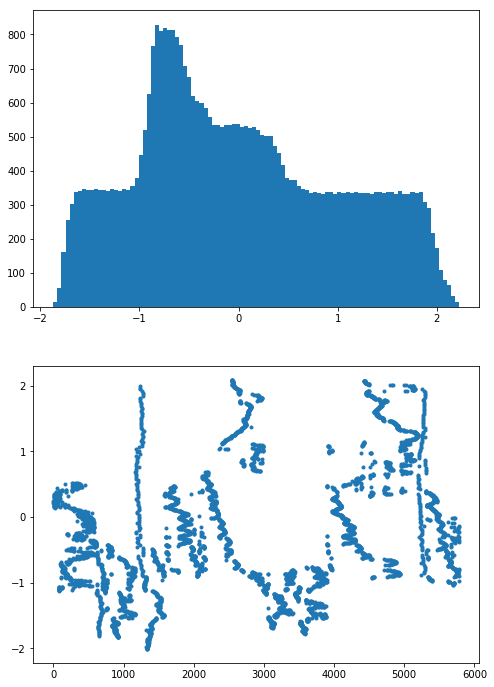

In [165]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(8, 12))
ax1.hist(y_train,100)
ax2.plot(np.arange(y_val.shape[0]),y_val, '.')

the locations are not independently and identically distributed. The y_train is not iid, the mean over all data is 0, and it lies far outside of the 2 std of the mean over the first 5785 points.

y_train is imbalanced.

## b.

In [3]:
# find and discard const columns in X_train
is_const = np.all(X_train_raw==X_train_raw[0,:],0)
const_idx = np.where(is_const)[0]
X_train = X_train_raw[:,np.logical_not(is_const)]

# find and discard replicate columns in X_train
uni, unique_idx = np.unique(X_train, axis=1,return_index=True)
repeat_idx = np.setdiff1d(np.arange(X_train.shape[1]),unique_idx)
X_train = X_train[:,np.sort(unique_idx)]

# discard const columns in X_val and X_test
const_mask = np.ones(X_val_raw.shape[1],dtype=bool)
const_mask[const_idx] = False
X_val = X_val_raw[:,const_mask]
X_test = X_test_raw[:,const_mask]

# discard replicate columns in X_val and X_test
repeat_mask = np.ones(X_val.shape[1],dtype=bool)
repeat_mask[repeat_idx] = False
X_val = X_val[:,repeat_mask]
X_test = X_test[:,repeat_mask]

print(const_idx)
print(repeat_idx)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


[ 59  69 179 189 351]
[ 76  77 185 195 283 354]
(40754, 373)
(5785, 373)
(6961, 373)


[ 59  69 179 189 351]

[ 76  77 185 195 283 354]

(40754, 373)

(5785, 373)

(6961, 373)


# 2. Linear Regression Baseline

## a.

In [4]:
def fit_linreg(X, yy, alpha):
    """ Fits a linear regression XW+b=y with L2 regularization"""
    X_bias = np.concatenate([np.ones((X.shape[0],1)), X], axis=1)
    reg = np.eye(X_bias.shape[1])*np.sqrt(alpha)
    reg[0,0]=0
    X_reg = np.concatenate([X_bias, reg], axis=0)
    yy_reg = np.concatenate([yy, np.zeros(X_bias.shape[1])])
    ww_b = np.linalg.lstsq(X_reg, yy_reg, rcond=None)[0]
    return ww_b[1:], ww_b[0]

def rtmsq_error(ww, bb, X, yy):
    """ Computes the root mean square error of y and the estimate XW+b"""
    res = yy-(X.dot(ww)+bb)
    return np.sqrt(res.dot(res)/X.shape[0])

In [151]:
alpha = 10
ww_lstsq, bb_lstsq = fit_linreg(X_train, y_train, alpha)
e_train_lstsq = rtmsq_error(ww_lstsq, bb_lstsq, X_train, y_train)
e_val_lstsq = rtmsq_error(ww_lstsq, bb_lstsq, X_val, y_val)
print(e_train_lstsq, e_val_lstsq)

0.355758911251752 0.42059251169915385


In [36]:
%timeit result = fit_linreg(X_train, y_train, alpha)

1.2 s ± 176 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
alpha = 10
ww_grad, bb_grad = fit_linreg_gradopt(X_train, y_train, alpha)
e_train_grad = rtmsq_error(ww_grad, bb_grad, X_train, y_train)
e_val_grad = rtmsq_error(ww_grad, bb_grad, X_val, y_val)
print(e_train_grad, e_val_grad)

0.35575973762757696 0.4206037540708194


In [38]:
%timeit result = fit_linreg_gradopt(X_train, y_train, alpha)

7.59 s ± 523 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Results aren't the same.
lstsq gets a lower error. Gradient-based optimisers learn slowly when it gets nearly to the minimum. It may never get to the real minimum. 
While the lstsq solves for the minimum analytically.

# 3. Decreasing and increasing the input dimensionality

## a.
### k=10

In [10]:
X_train_cen = X_train - np.mean(X_train,0)
X_val_cen = X_val - np.mean(X_train,0)

alpha = 10
K = 10
V = pca_zm_proj(X_train_cen, K=K)
X_train_red = X_train_cen.dot(V).dot(V.T)
X_val_red = X_val_cen.dot(V).dot(V.T)
ww,bb = fit_linreg(X_train_red, y_train, alpha)

e_train = rtmsq_error(ww, bb, X_train_red, y_train)
e_val = rtmsq_error(ww, bb, X_val_red, y_val)
print(e_train, e_val)

0.572917984815683 0.5717489417505967


### k=100

In [9]:
X_train_cen = X_train - np.mean(X_train,0)
X_val_cen = X_val - np.mean(X_train,0)

alpha = 10
K = 100
V = pca_zm_proj(X_train_cen, K=K)
X_train_red = X_train_cen.dot(V).dot(V.T)
X_val_red = X_val_cen.dot(V).dot(V.T)
ww,bb = fit_linreg(X_train_red, y_train, alpha)

e_train = rtmsq_error(ww, bb, X_train_red, y_train)
e_val = rtmsq_error(ww, bb, X_val_red, y_val)
print(e_train, e_val)

0.4106364907174908 0.4328303985139608


training error goes up because reduced data generates more residual.

We could search for the optimal K:

In [11]:
X_train_cen = X_train - np.mean(X_train,0)
X_val_cen = X_val - np.mean(X_val,0)
alpha = 10

step = 10
stats = []
for K in range(step,X_train.shape[1],step):  
    V = pca_zm_proj(X_train_cen, K=K)
    X_train_red = X_train_cen.dot(V).dot(V.T)+np.mean(X_train,0)
    X_val_red = X_val_cen.dot(V).dot(V.T)+np.mean(X_val,0)
    ww,bb = fit_linreg(X_train_red, y_train, alpha)
    
    e_train = rtmsq_error(ww, bb, X_train_red, y_train)
    e_val = rtmsq_error(ww, bb, X_val_red, y_val)
    stats.append([K, e_train, e_val])
    print("K={0}, err(train)={1:.4f}, err(valid)={2:.4f}".format(K, e_train, e_val))

K=10, err(train)=0.5729, err(valid)=0.5717
K=20, err(train)=0.4740, err(valid)=0.5150
K=30, err(train)=0.4484, err(valid)=0.4565
K=40, err(train)=0.4375, err(valid)=0.4527
K=50, err(train)=0.4306, err(valid)=0.4398
K=60, err(train)=0.4271, err(valid)=0.4446
K=70, err(train)=0.4232, err(valid)=0.4460
K=80, err(train)=0.4191, err(valid)=0.4405
K=90, err(train)=0.4167, err(valid)=0.4376
K=100, err(train)=0.4106, err(valid)=0.4328
K=110, err(train)=0.4053, err(valid)=0.4284
K=120, err(train)=0.4016, err(valid)=0.4385
K=130, err(train)=0.3973, err(valid)=0.4388
K=140, err(train)=0.3951, err(valid)=0.4439
K=150, err(train)=0.3935, err(valid)=0.4462
K=160, err(train)=0.3894, err(valid)=0.4481
K=170, err(train)=0.3850, err(valid)=0.4393
K=180, err(train)=0.3839, err(valid)=0.4398
K=190, err(train)=0.3825, err(valid)=0.4383
K=200, err(train)=0.3806, err(valid)=0.4356
K=210, err(train)=0.3797, err(valid)=0.4376
K=220, err(train)=0.3782, err(valid)=0.4390
K=230, err(train)=0.3768, err(valid)=0.43

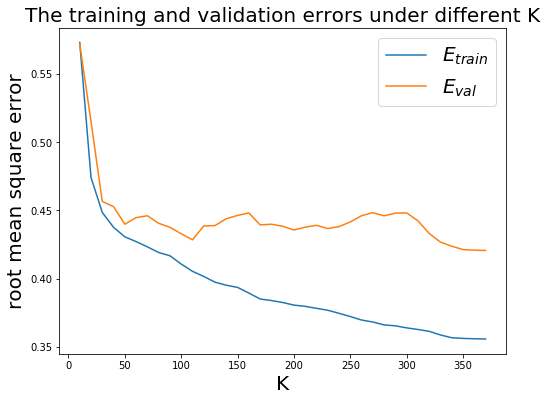

In [83]:
def pca_rank(X):
    if np.max(np.abs(np.mean(X,0))) > 1e-9:
        raise ValueError('Data is not zero mean.')
    E, V = np.linalg.eig(np.dot(X.T, X))
    return np.argsort(E)[::-1]


fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
stats = np.array(stats)
ax1.plot(stats[:,0],stats[:,1], label="$E_{train}$")
ax1.plot(stats[:,0],stats[:,2], label="$E_{val}$")
ax1.legend(prop={'size': 20})
ax1.set_title("The training and validation errors under different K",fontsize=20)
ax1.set_ylabel("root mean square error",fontsize=20)
ax1.set_xlabel("K",fontsize=20)
fig.savefig("pca.pdf")
#dim_rank = pca_rank(X_train-np.mean(X_train,0))
#ww_ranked = ww_lstsq[dim_rank]
#ax2.plot(np.arange(ww_ranked.shape[0]),np.abs(ww_ranked),'-')

Actually the original features doesn't cause overfitting.

## b.

inputs are either -0.25 or greater or equal to 0. with 80% of time being 0 and -0.25.

0.8036237433757057 0.19637625662429425 1.0


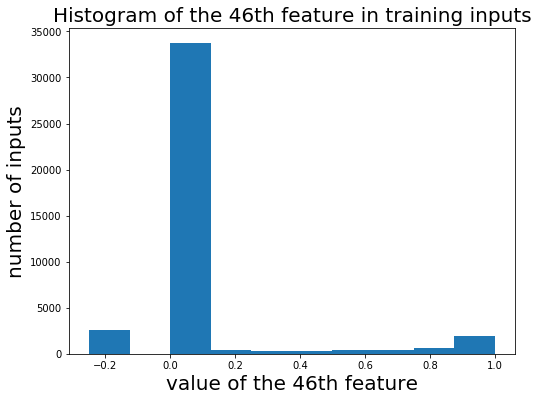

In [92]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
ax1.hist(X_train[:,45])
ax1.set_title("Histogram of the 46th feature in training inputs",fontsize=20)
ax1.set_ylabel("number of inputs",fontsize=20)
ax1.set_xlabel("value of the 46th feature",fontsize=20)
fig.savefig("hist.pdf")

bi_fraction = np.mean((X_train == -0.25)+(X_train == 0.0))
rest_fraction = np.mean((X_train > 0.0))
print(bi_fraction,rest_fraction,bi_fraction+rest_fraction)

In [85]:
aug_fn = lambda X: np.concatenate([X, X==0, X<0], axis=1)
alpha = 10
ww, bb = fit_linreg(aug_fn(X_train), y_train, alpha)
e_train = rtmsq_error(ww, bb, aug_fn(X_train), y_train)
e_val = rtmsq_error(ww, bb, aug_fn(X_val), y_val)
print(e_train, e_val)


0.3178324826889212 0.3769885722393182


error goes down because we eliminate noise from variance of the "greater than 0" feature.

# 4. Invented classification tasks

In [12]:
def fit_logreg_gradopt(X, yy, alpha):
    D = X.shape[1]
    args = (X, yy, alpha)
    init = (np.zeros(D), np.array(0))
    ww, bb = minimize_list(logreg_cost, init, args)
    return ww, bb

In [13]:
K = 10 # number of thresholded classification problems to fit
mx = np.max(y_train); mn = np.min(y_train); hh = (mx-mn)/(K+1)
thresholds = np.linspace(mn+hh, mx-hh, num=K, endpoint=True)
W = np.zeros((X_train.shape[1],K))
B = np.zeros(K)
for kk in range(K):
    labels = y_train > thresholds[kk]
    W[:,kk], B[kk] = fit_logreg_gradopt(X_train, labels, alpha)

In [14]:
X_train_class = 1/(1 + np.exp(-(X_train.dot(W)+B)))
X_val_class = 1/(1 + np.exp(-(X_val.dot(W)+B)))
alpha = 10
ww_q4, bb_q4 = fit_linreg(X_train_class, y_train, alpha)
e_train = rtmsq_error(ww_q4, bb_q4, X_train_class, y_train)
e_val = rtmsq_error(ww_q4, bb_q4, X_val_class, y_val)
print(e_train, e_val)

0.13825872496409866 0.25212914603320613


# 5. Small neural network

In [15]:
def fit_nn_gradopt(X, yy, K, alpha, init):
    D = X.shape[1]
    args = (X, yy, alpha)
    return minimize_list(nn_cost, init, args)

def nn_rtmsq_error(params, X, yy):
    pp = nn_cost(params,X)
    res = yy-pp
    return np.sqrt(res.dot(res)/X.shape[0])


## Q4 init

In [16]:
K=10
D = X_train.shape[1]
alpha = 10
init = (ww_q4, bb_q4, W.T, B)
params_fit = fit_nn_gradopt(X_train, y_train, K, alpha, init)
e_train = nn_rtmsq_error(params_fit, X_train, y_train)
e_val = nn_rtmsq_error(params_fit, X_val, y_val)
print(e_train, e_val)

0.10490889447473462 0.2548009442451099


## normal init

In [153]:
K=10
D = X_train.shape[1]
alpha = 20

e_train = []
e_val = []
for i in range(1):
    init = (np.zeros(K), np.array(0), np.random.randn(K,D),np.zeros(K))
    params_fit = fit_nn_gradopt(X_train, y_train, K, alpha, init)
    e_train.append(nn_rtmsq_error(params_fit, X_train, y_train))
    e_val.append(nn_rtmsq_error(params_fit, X_val, y_val))

print(np.mean(e_train), np.mean(e_val))
print(np.std(e_train)/np.sqrt(10), np.std(e_val)/np.sqrt(10))

0.12491955118860724 0.26220855767837364
0.0 0.0


## glorot

In [138]:
K=10
D = X_train.shape[1]
alpha = 10
init_interval = np.sqrt(6/(K+D))

e_train = []
e_val = []
for i in range(10):
    init = (np.zeros(K), np.array(0), np.random.uniform(-init_interval,init_interval,(K,D)),np.zeros(K))
    params_fit = fit_nn_gradopt(X_train, y_train, K, alpha, init)
    e_train.append(nn_rtmsq_error(params_fit, X_train, y_train))
    e_val.append(nn_rtmsq_error(params_fit, X_val, y_val))

print(np.mean(e_train), np.mean(e_val))
print(np.std(e_train)/np.sqrt(10),np.std(e_val)/np.sqrt(10))

0.10292617110443396 0.25959768555702717
0.0009882558938780163 0.002388805928463283


# 6. what next

In [161]:
alpha = 10

K_list=[k for k in range(6,30,1)]
e_val=[]
for K in K_list:
    mx = np.max(y_train); mn = np.min(y_train); hh = (mx-mn)/(K+1)
    thresholds = np.linspace(mn+hh, mx-hh, num=K, endpoint=True)
    V = np.zeros((X_train.shape[1],K))
    V_b = np.zeros(K)
    for kk in range(K):
        labels = y_train > thresholds[kk]
        V[:,kk], V_b[kk] = fit_logreg_gradopt(X_train, labels, alpha)
    X_train_class = 1/(1 + np.exp(-(X_train.dot(V)+V_b)))
    X_val_class = 1/(1 + np.exp(-(X_val.dot(V)+V_b)))
    
    ww, bb = fit_linreg(X_train_class, y_train, alpha)
    e_val.append(rtmsq_error(ww, bb, X_val_class, y_val))

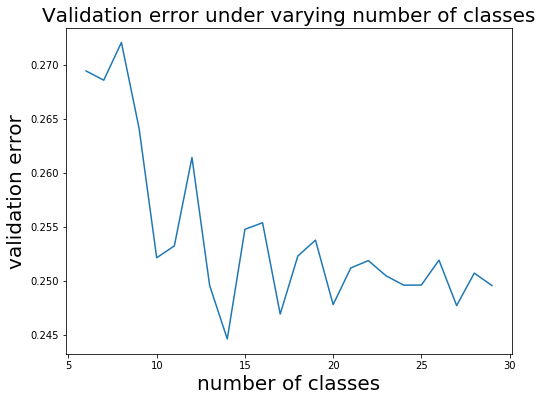

In [163]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
ax1.plot(K_list,e_val)
ax1.set_title("Validation error under varying number of classes",fontsize=20)
ax1.set_ylabel("validation error",fontsize=20)
ax1.set_xlabel("number of classes",fontsize=20)
fig.savefig("cls.pdf")

In [ ]:
alpha_list=np.arange()
e_val=[]
for K in K_list:
    mx = np.max(y_train); mn = np.min(y_train); hh = (mx-mn)/(K+1)
    thresholds = np.linspace(mn+hh, mx-hh, num=K, endpoint=True)
    V = np.zeros((X_train.shape[1],K))
    V_b = np.zeros(K)
    for kk in range(K):
        labels = y_train > thresholds[kk]
        V[:,kk], V_b[kk] = fit_logreg_gradopt(X_train, labels, alpha)
    X_train_class = 1/(1 + np.exp(-(X_train.dot(V)+V_b)))
    X_val_class = 1/(1 + np.exp(-(X_val.dot(V)+V_b)))
    
    ww, bb = fit_linreg(X_train_class, y_train, alpha)
    e_val.append(rtmsq_error(ww, bb, X_val_class, y_val))

In [170]:
np.arange(-2,2,0.2)


array([-2.0000000e+00, -1.8000000e+00, -1.6000000e+00, -1.4000000e+00,
       -1.2000000e+00, -1.0000000e+00, -8.0000000e-01, -6.0000000e-01,
       -4.0000000e-01, -2.0000000e-01, -4.4408921e-16,  2.0000000e-01,
        4.0000000e-01,  6.0000000e-01,  8.0000000e-01,  1.0000000e+00,
        1.2000000e+00,  1.4000000e+00,  1.6000000e+00,  1.8000000e+00])